# Problem Set #2, Preston Mui

# Calorie Demand

In [19]:
# Preparation to use the dataset
using DataFrames, Gadfly
data = readtable("RPS_calorie_data.out");

#### 2 Using the power series basis, construct a new basis that is orthogonal to the design points ($K = 12$)

In [20]:
# Extract the matrices from the data
K = 12
Y = convert(Array,data[:Y0tc])
X = zeros(size(data)[1],K)

# Construct the basis vectors
for k = 1:K
    X[:,k] = data[:X0te].^(k-1)
end

# Function for Gram-Schmidt
function GSO(X::Array{Float64})
    # Orthogonalization
    K = size(X)[2]
    W = copy(X)
    for k = 1:K
        for i = 1:k-1
            W[:,k] -= (dot(X[:,k],W[:,i]) / dot(W[:,i],W[:,i])) * W[:,i]
        end
    end
    # Normalization
    for k = 1:K
        W[:,k] = W[:,k] / sqrt((dot(W[:,k],W[:,k])/length(W)[1]))
    end
    return W
end;

#### Let $W_i$ denote the $K \times 1$ vector of orthonormal basis functions for household $i$. Compute the Least Squares Fit:

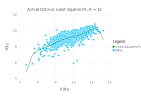

In [21]:
# MLE Estimate of basis function coefficients
W = GSO(X)
theta = W'*Y / length(W)[1]
m = W * theta
plot(layer(x=X[:,2], y=m, Geom.line,Theme(default_color=colorant"green")),
    layer(x=X[:,2], y=Y, Geom.point),
    Guide.XLabel("X0te"),
    Guide.YLabel("Y0tc"),
    Guide.Title("Actual Data vs. Least Squares Fit, K = $K"),
    Guide.manual_color_key("Legend",["Least Squares Fit","Data"],["green","deepskyblue"]))

#### 3 Using the shrinkage estimator, estimate $m(X_i)$. Plot this on the unsmoothed data.

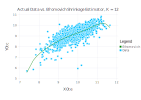

In [22]:
# MLE of Variance
sigma2 = norm(Y-m) / (length(Y)- K)

# Shrinkage Coefficients
function efromovich(Z::Array{Float64,1},var::Float64,N::Int64)
    shrinkage = similar(Z)
    for k = 1:length(shrinkage)
        shrinkage[k] = max(1 - (var/N)/Z[k]^2,0)
    end
    return shrinkage
end

# Plot the Efromovich
muse = W*(efromovich(theta,sigma2,length(Y)).*theta)
plot(layer(x=X[:,2], y=muse, Geom.line,Theme(default_color=colorant"green")),
    layer(x=X[:,2], y=Y, Geom.point),
    Guide.XLabel("X0te"),
    Guide.YLabel("Y0tc"),
    Guide.Title("Actual Data vs. Efromovich Shrinkage Estimator, K = $K"),
    Guide.manual_color_key("Legend",["Efromovich","Data"],["green","deepskyblue"]))

Comments: The Efromovich Shrinkage Estimator is a smoother version of the Maximum Likelihood Estimator. Notably, the line does not curve down as much on the tails.

#### 4 Compute the Soft Threshold Estimate

Consider the SURE Risk of the soft threshold estimator $\hat{\theta}_k$. Say, without loss of generality, that the $Z_k$ are ordered such that $|Z_1| \leq |Z_2| \leq \cdots \leq |Z_K|$. Then, say that $\lambda \in [Z_m, Z_{m+1})$ for some $m \in 1, \cdots, K$. Then,

\begin{align*}
    \hat{R}_{SURE} &= K\frac{\sigma^2}{N} - 2m \frac{\sigma^2}{N} + \sum_{k=1}^m Z_k^2 + (K-m) \lambda^2
\end{align*}

This is increasing in $\lambda$ on this interval, so the risk-minimizing choice of $\lambda$ on this interval is $\lambda = |Z_m|$. So, to minimize risk, I will iterate through $m = 1, \cdots, K$ and compare estimates of risk for $\lambda = Z_m$ for each $m$.

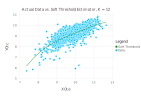

In [23]:
# Function to calculate RSURE of Wasserman Soft Threshold using the MLE's of Z and Sigma
function risk_wasserman(Z::Array{Float64,1}, lambda::Float64, var::Float64, N::Int64)
    K = length(Z)
    risk = K * var / N
    for k = 1:length(Z)
        if abs(Z[k]) <= lambda
            risk += Z[k]^2 - 2 * var / N
        else
            risk += lambda^2
        end
    end
    return risk
end

# Create Wasserman Soft Threshold
function wasserman(Z::Array{Float64,1}, var::Float64, N::Int64)
    
    # Find lambda to minimize risk
    lambda_choices = sort(abs(Z))
    risks = similar(Z)
    for m = 1:K
        risks[m] = risk_wasserman(Z,lambda_choices[m],var,N)
    end
    lambda = lambda_choices[findmin(risks)[2]]
    
    # Create Wasserman estimator    
    theta_w = similar(Z)
    for k = 1:length(Z)
        theta_w[k] = sign(Z[k]) * (abs(Z[k]) - lambda) * (abs(Z[k]) > lambda)
    end
    return theta_w
end

# Plot the Soft Threshold Estimator on the Data
msoft = W*wasserman(theta,sigma2,length(Y))
plot(layer(x=X[:,2], y=msoft, Geom.line,Theme(default_color=colorant"green")),
    layer(x=X[:,2], y=Y, Geom.point),
    Guide.XLabel("X0te"),
    Guide.YLabel("Y0tc"),
    Guide.Title("Actual Data vs. Soft Threshold Estimator, K = $K"),
    Guide.manual_color_key("Legend",["Soft Threshold","Data"],["green","deepskyblue"]))

## Income and Geography

In [24]:
# Code to read in the data
hjfile = open("HallJones400.asc")
hjdata = readlines(hjfile)

# Read in logYL and Latitude, skipping any observation that is
logYL = Array(Float64,0)
latitude = Array(Float64,0)
for line = 210:361
    if isnan(parse(Float64,hjdata[line][46:54]))
        continue
    end
    push!(logYL,parse(Float64,hjdata[line][46:54]))
    push!(latitude,parse(Float64,hjdata[line][196:203]))
end

#### 2 Using the power series basis, construct an Orthogonal Basis

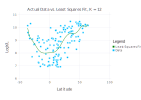

In [25]:
# Construct the basis vectors
K = 12
X = zeros(length(latitude),K)
for k = 1:K
    X[:,k] = latitude.^(k-1)
end

W = GSO(X)
theta = inv(W'*W) * W' * logYL
m = W * theta

plot(layer(x=X[:,2], y=m, Geom.line,Theme(default_color=colorant"green")),
    layer(x=X[:,2], y=logYL, Geom.point),
    Guide.XLabel("Latitude"),
    Guide.YLabel("LogY/L"),
    Guide.Title("Actual Data vs. Least Squares Fit, K = $K"),
    Guide.manual_color_key("Legend",["Least Squares Fit","Data"],["green","deepskyblue"]))

#### 3 Use the Efromovich Shrinkage Estimator

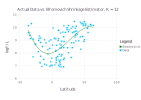

In [26]:
# MLE of Variance
sigma2 = norm(logYL - m) / (length(logYL)- K)

# Plot data
muse = W*(efromovich(theta,sigma2,length(logYL)).*theta)
plot(layer(x=X[:,2], y=muse, Geom.line,Theme(default_color=colorant"green")),
    layer(x=X[:,2], y=logYL, Geom.point),
    Guide.XLabel("Latitude"),
    Guide.YLabel("logY / L"),
    Guide.Title("Actual Data vs. Efromovich Shrinkage Estimator, K = $K"),
    Guide.manual_color_key("Legend",["Efromovich","Data"],["green","deepskyblue"]))

#### 4 Soft Threshold Estimate

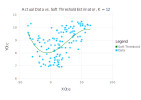

In [27]:
# Plot the Soft Threshold Estimator on the Data
msoft = W*wasserman(theta,sigma2,length(logYL))
plot(layer(x=X[:,2], y=msoft, Geom.line,Theme(default_color=colorant"green")),
    layer(x=X[:,2], y=logYL, Geom.point),
    Guide.XLabel("X0te"),
    Guide.YLabel("Y0tc"),
    Guide.Title("Actual Data vs. Soft Threshold Estimator, K = $K"),
    Guide.manual_color_key("Legend",["Soft Threshold","Data"],["green","deepskyblue"]))